### Metropolis-Hastings

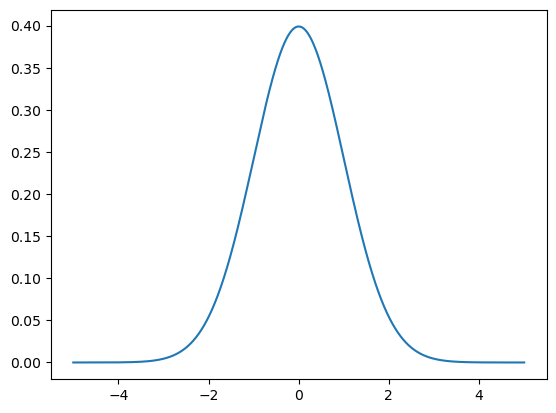

In [194]:
import numpy as np

def normal(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

from matplotlib import pyplot as plt

x = np.linspace(-5, 5, 1000)
plt.plot(x, normal(x))
plt.show()

We begin with a simple use case of the Metropolis-Hastings algorithim, attempting to sample a normal distribution. To start we select a random point $x_t$, and propose a next point $x'$. The acceptance ratio is then calculated, given by $\alpha = {f(x')}/{x_t}$. In this case, the function $g$ that is used to suggest $x'$ must be symmetric hence a normal distribution has been used. If $\alpha$ is larger than a uniformly generated number between 0 and 1 we accept the sample and set $x_t = x'$, if not we remain with sample $x_t$.

This process iterates based upon the desired number of samples, and the results are plotted as a histogram below. An important parameter to consider is the step size. A step size that is too small will result in slow exploration of the probability density space, and potentially becoming stuck in local areas of probability density, this is typically indicated by an acceptance rate that is too high. A step size too large will result in high rejection rates as the walker (moving sample) jumps to low probability regions, this is indicated by a low acceptance rate.

The ideal acceptance rate is between 20% and 50% so the step size has been tuned to fall within this region.

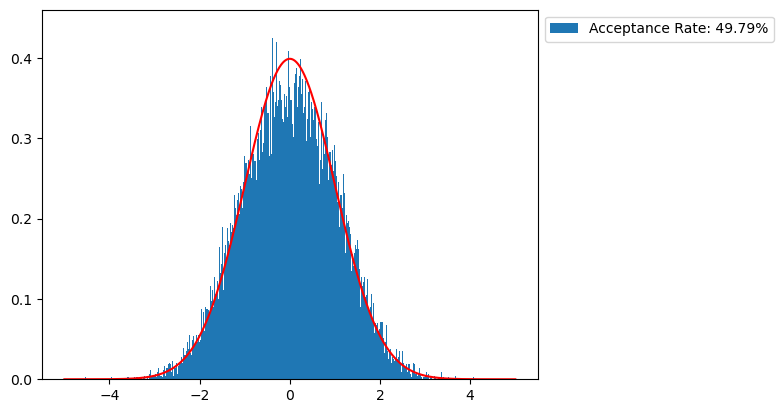

In [195]:
def mh(num_samples, step_size):
    current = np.random.normal()
    accepted = 0

    for _ in range(num_samples):
        proposed = current + np.random.normal(scale = step_size)
        
        acceptance_ratio = min(1, normal(proposed) / normal(current))

        if np.random.rand() < acceptance_ratio:
            current = proposed
            samples.append(current)
            accepted += 1
    
    return samples, accepted

num_samples = 100000
step_size = 2

samples = []
accepted_samples, accepted = mh(num_samples, step_size)

acceptance_rate = (accepted / num_samples) * 100

plt.hist(accepted_samples, bins=1000, density = True, label = f'Acceptance Rate: {acceptance_rate:.2f}%')
plt.plot(x, normal(x), color='r')
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
plt.show()

We can see that the algorithim does a relatively good job of sampling the probaility space of a normal distribution.

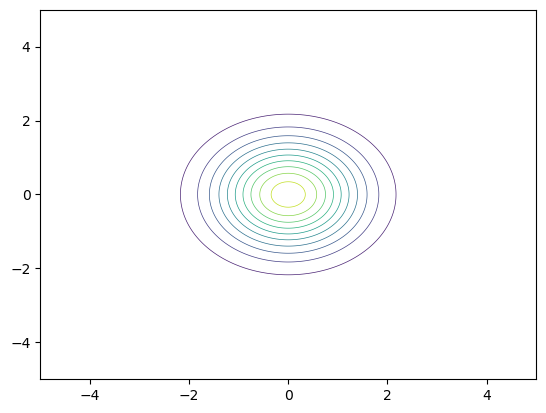

In [196]:
def psi(a, b):
    x_val = np.exp(-a**2/2)/np.sqrt(2*np.pi)
    y_val = np.exp(-b**2/2)/np.sqrt(2*np.pi)

    return x_val * y_val

a = np.linspace(-5, 5, 1000)
b = np.linspace(-5, 5, 1000)

X, Y = np.meshgrid(a, b)
Z = psi(X, Y)

plt.contour(X, Y, Z, levels = 10, linewidths = 0.5)
plt.show()

Next we attempt to sample a 2 dimensional space using the same method, the function is simply expanded to 2 dimensions using a meshgrid and proposed, current, and acceptance ratio values take 2 parameters in an array. Again the step size has been tuned to give an acceptance rate within the desired range.

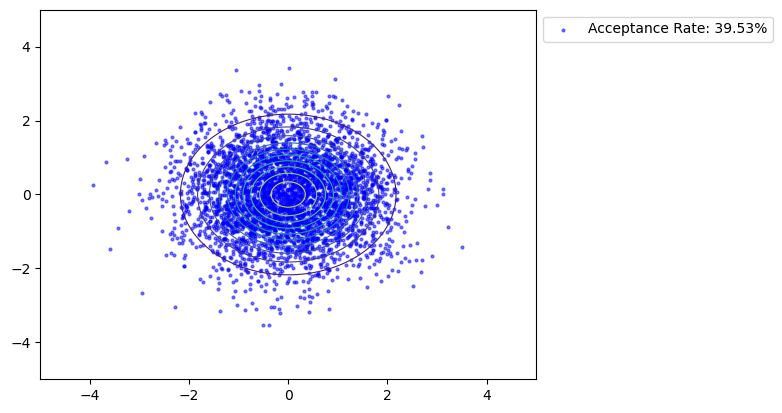

In [197]:
samples = []

def mh_2d(num_samples, step_size):
    current = [np.random.normal(), np.random.normal()]
    accepted = 0

    for _ in range(num_samples):
        proposed = current + np.array([np.random.normal(scale = step_size), np.random.normal(scale = step_size)])
        acceptance_ratio = psi(proposed[0], proposed[1])/psi(current[0], current[1])

        if np.random.rand() < acceptance_ratio:
            current = proposed
            samples.append(current)
            accepted += 1
    
    return samples, accepted

num_samples = 10000
step_size = 1.5

samples, accepted = mh_2d(num_samples, step_size)

acceptance_rate = (accepted / num_samples) * 100

plt.contour(X, Y, Z, levels = 10, linewidths = 0.8)
plt.scatter(np.array(samples)[:, 0], np.array(samples)[:, 1], color = 'b', alpha = 0.5, s = 4, label=f'Acceptance Rate: {acceptance_rate:.2f}%')
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
plt.show()

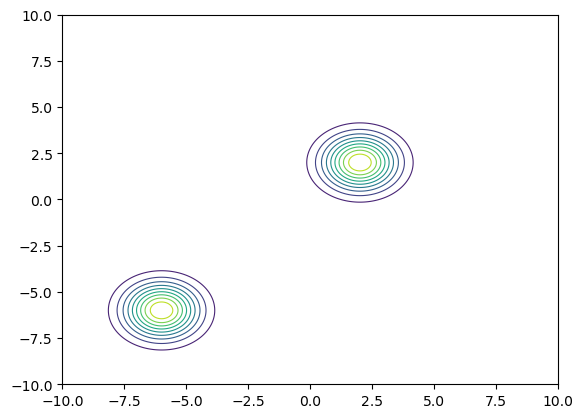

In [198]:
def psi(x, y):
    peak1 = np.exp((-(x-2)**2 + -(y-2)**2)/2) / np.sqrt(2*np.pi)
    peak2 = np.exp((-(x+6)**2 + -(y+6)**2)/2) / np.sqrt(2*np.pi)
    
    return peak1 + peak2

x = np.linspace(-10, 10, 1000)
y = np.linspace(-10, 10, 1000)

X, Y = np.meshgrid(x, y)
Z = psi(X, Y)

plt.contour(X, Y, Z, levels = 10, linewidths = 0.8)
plt.show()

A slightly more complicated example may involve a space in which there are 2 distinct regions of probability density.

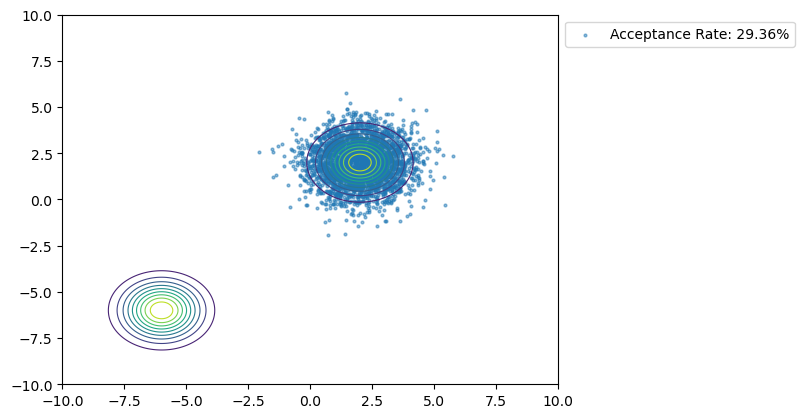

In [199]:
def mh(num_samples, step_size):
    
    samples = []
    current = [np.random.uniform(-10, 10), np.random.uniform(-10, 10)]
    num_accepted = 0

    for _ in range(num_samples):
        proposed = [current[0] + np.random.normal(scale = step_size), current[1] + np.random.normal(scale = step_size)]

        acceptance_ratio = min(1, psi(proposed[0], proposed[1])/psi(current[0], current[1]))

        if acceptance_ratio > np.random.rand():
            current = proposed
            samples.append(current)
            num_accepted += 1
    
    return samples, num_accepted


num_samples = 10000
step_size = 2

samples, num_accepted = mh(num_samples, step_size)

acceptance_rate = (num_accepted/num_samples)*100

plt.scatter([sample[0] for sample in samples], [sample[1] for sample in samples], alpha = 0.5, s = 4, label = f'Acceptance Rate: {acceptance_rate:.2f}%')
plt.contour(X, Y, Z, levels = 10, linewidths = 0.8)
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
plt.show()

We see that typically (not always) the walker only samples one of the regions, completley failing to sample the other. An attempted solution to this may be to increase the step size in order to bridge the gap, however this would result in an acceptance rate that is too low. As mentioned above this would degrade the sampling quality. A better solution is to propagate multiple walkers, each starting in a different random location in the space.

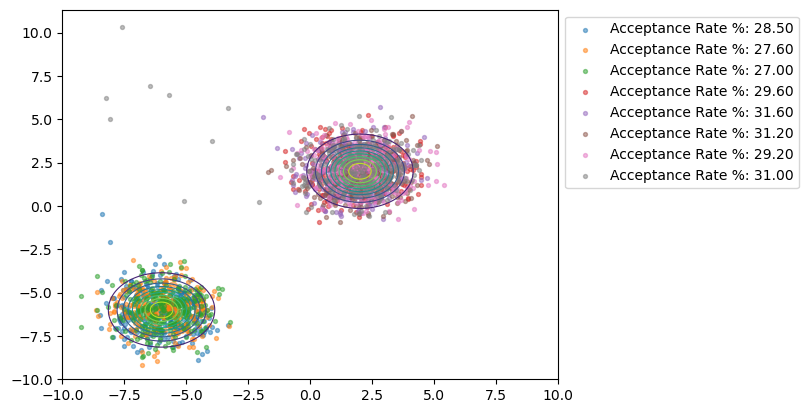

In [201]:
def psi(x, y):
    peak1 = np.exp((-(x-2)**2 + -(y-2)**2)/2) / np.sqrt(2*np.pi)
    peak2 = np.exp((-(x+6)**2 + -(y+6)**2)/2) / np.sqrt(2*np.pi)
    
    return peak1 + peak2

def mh(num_walkers, num_samples, stepsize):
    samples = [[] for _ in range(num_walkers)]
    acceptance_rates = np.zeros(num_walkers)

    current = [[np.random.uniform(-10, 10), np.random.uniform(-10, 10)] for _ in range(num_walkers)]

    for _ in range(num_samples):
        proposed = []

        for i in range(num_walkers):
            proposed.append([current[i][0] + np.random.normal(scale = step_size), current[i][1] + np.random.normal(scale = step_size)])

        acceptance_ratios = [min(1, psi(proposed[i][0], proposed[i][1]) / psi(current[i][0], current[i][1])) for i in range(num_walkers)]

        for i in range(num_walkers):
            if acceptance_ratios[i] > np.random.rand():
                current[i] = proposed[i]
                samples[i].append(current[i])
                acceptance_rates[i] += 1

    return samples, acceptance_rates

num_walkers = 8
num_steps = 1000
step_size = 2

walker_samples, acceptance_rates = mh(num_walkers, num_steps, step_size)

plt.contour(X, Y, Z, levels = 10, linewidths = 0.8)

for walker, acceptance_rate in zip(walker_samples, acceptance_rates):
    plt.scatter([sample[0] for sample in walker],[sample[1] for sample in walker], alpha = 0.5, s = 8, label = f'Acceptance Rate %: {(acceptance_rate / num_steps)*100 :.2f}')
    
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
plt.show()

The plot shows that this method has worked much better, with both regions of probability density being adequately sampled.